# Torch Connector

This tutorial shows how the `TorchConnector` allows to use any `NeuralNetwork` from Qiskit Machine Learning and integrate it in a PyTorch workflow. The `TorchConnector` takes any `NeuralNetwork` and makes it available as a PyTorch `Module`.

### Content:

#### Part 1: Simple Classification & Regression
- Classification
    - Classification with PyTorch and the `OpflowQNN`
    - Classification with PyTorch and the `CircuitQNN`
- Regression
    - Regression with PyTorch and the `OpflowQNN`

#### Part 2: MNIST Classification


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import LBFGS

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

# Part 1: Simple Classification & Regression

## Classification

First, we show how the `TorchConnector` can be used to use a Quantum `NeuralNetwork` to solve a classification tasks. Therefore, we generate a simple random data set.

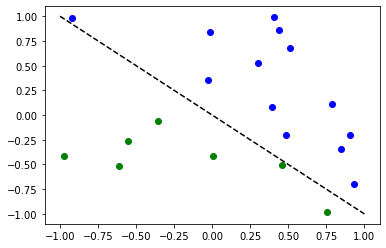

In [2]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

### Classification with PyTorch and the `OpflowQNN`

Linking an `OpflowQNN` to PyTorch is relatively straight-forward. Here we illustrate this using the `TwoLayerQNN`.

In [3]:
# set up QNN
qnn1 = TwoLayerQNN(num_qubits=num_inputs, quantum_instance=qi)

# set up PyTorch module
model1 = TorchConnector(qnn1)

In [4]:
# test with a single input
x = Tensor(X[0, :])
model1(x)

tensor([0.1654], grad_fn=<_TorchNNFunctionBackward>)

In [5]:
# define model and optimizer
optimizer = LBFGS(model1.parameters())

# start training
model1.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)  # initialize gradient
    
    loss = 0.0                             # initialize loss
    for x, y_target in zip(X, y):          # compute batch loss
        output = model1(Tensor(x))         # forward pass
        loss += (output - y_target)**2     # calculate loss
        
    loss.backward()                        # backward pass
    
    print(loss.item())                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

23.21629524230957
21.813167572021484
25.015100479125977
24.128360748291016
22.476152420043945
28.100976943969727
20.279247283935547
20.8486270904541
26.146244049072266
22.678077697753906
25.07236099243164
20.99858856201172
20.092491149902344
17.993118286132812
17.864490509033203
17.80898666381836
17.799354553222656
17.797426223754883
17.797327041625977
17.797100067138672


tensor([23.2163], grad_fn=<AddBackward0>)

Accuracy: 0.6


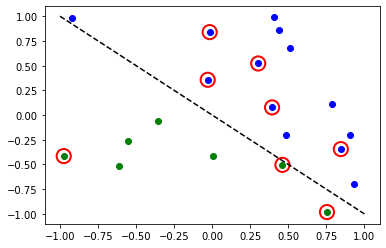

In [6]:
# evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print('Accuracy:', sum(y_predict == y)/len(y))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

### Classification with PyTorch and the `CircuitQNN`

Linking an `CircuitQNN` to PyTorch requires the correct setup, otherwise backpropagation is not possible.

In [7]:
feature_map = ZZFeatureMap(num_inputs)
var_form = RealAmplitudes(num_inputs, entanglement='linear', reps=1)

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(var_form, range(num_inputs))

parity = lambda x: np.sum(x) % 2

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=var_form.parameters, 
                        interpret=parity, dense=True, output_shape=2, quantum_instance=qi)

# set up PyTorch module
model2 = TorchConnector(qnn2)

In [8]:
# test with a single input
x = Tensor(X[0, :])
model2(x)

tensor([[0.3097, 0.6903]], grad_fn=<_TorchNNFunctionBackward>)

In [9]:
# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()
    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x))                         # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure)

14.792081832885742
14.190685272216797
13.768144607543945
13.304940223693848
13.492995262145996
12.808493614196777
13.061164855957031
12.763443946838379
12.758014678955078
12.754119873046875
12.737550735473633
12.735100746154785
12.734943389892578
12.734925270080566
12.734925270080566


tensor(14.7921, grad_fn=<AddBackward0>)

Accuracy: 0.7


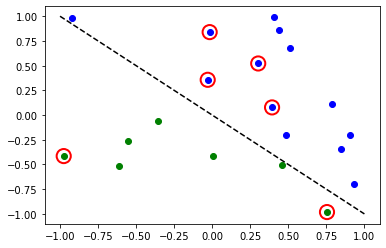

In [10]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == y01)/len(y01))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

## Regression 

We use a model based on the `TwoLayerQNN` to also illsutrate an regression task.

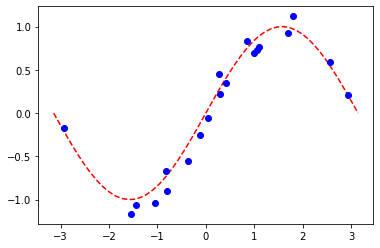

In [11]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)

X = (ub - lb)*np.random.rand(num_samples, 1) + lb
y = f(X) + eps*(2*np.random.rand(num_samples, 1)-1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')
plt.plot(X, y, 'bo')
plt.show()

In [12]:
# construct simple feature map
param_x = Parameter('x')
feature_map = QuantumCircuit(1, name='fm')
feature_map.ry(param_x, 0)

# construct simple feature map
param_y = Parameter('y')
var_form = QuantumCircuit(1, name='vf')
var_form.ry(param_y, 0)

# construct QNN
qnn3 = TwoLayerQNN(1, feature_map, var_form, quantum_instance=qi)
print(qnn3.operator)

# set up PyTorch module
model3 = TorchConnector(qnn3)

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
       ┌───────┐┌───────┐
  q_0: ┤ fm(x) ├┤ vf(y) ├
       └───────┘└───────┘
  )
])


In [13]:
# define model and optimizer
optimizer = LBFGS(model3.parameters())

# start training
model3.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)  # initialize gradient
    
    loss = 0.0                             # initialize loss
    for x, y_target in zip(X, y):          # compute batch loss
        output = model3(Tensor(x))         # forward pass
        loss += (output - y_target[0])**2  # calculate loss
        
    loss.backward()                        # backward pass
    
    print(loss.item())                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

36.351078033447266
20.08730697631836
1.7611143589019775
2.553478717803955
3.7583658695220947
38.7161979675293
0.24585051834583282
1.2807297706604004
0.23578330874443054
0.23578152060508728
0.23578153550624847


tensor([36.3511], grad_fn=<AddBackward0>)

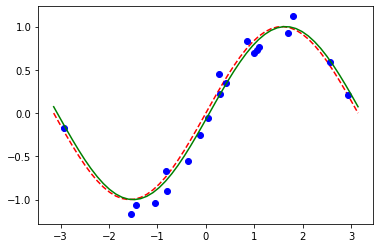

In [14]:
# plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')

# plot data
plt.plot(X, y, 'bo')

# plot fitted line
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, 'g-')
plt.show()

# Part 2: MNIST Example

In [15]:
# TODO